In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import StackingClassifier, VotingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imb_pipeline
from category_encoders.target_encoder import TargetEncoder

import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.integration import LightGBMPruningCallback

import shap

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

%matplotlib inline

/Users/dorukcanga/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read Data

In [2]:
train_data = pd.read_pickle('./data/train_file_eng.pkl')

In [9]:
test_data = pd.read_excel('./data/test_file.xlsx')

In [10]:
train_data.shape, test_data.shape

((32910, 17), (40, 14))

# Feature Engineering for Test Data

In [14]:
test_data.job.replace('unknown', 'admin.', inplace=True)
test_data.marital.replace('unknown', 'married', inplace=True)
test_data.education.replace('illiterate', 'unknown', inplace=True)
test_data.default.replace('yes', 'unknown', inplace=True)

In [16]:
test_data['quarter'] = ['q1' if x in ['jan', 'feb', 'mar'] else
                         'q2' if x in ['apr', 'may', 'jun'] else
                         'q3' if x in ['jul', 'aug', 'sep'] else
                         'q4' for x in test_data.month]

# Final Model

In [17]:
feature_set = ['age', 'job', 'education', 'default',
               'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
               'poutcome', 'quarter']

cat_features = ['job', 'education', 'default',
                'contact', 'month', 'day_of_week', 'poutcome', 'quarter']

num_features = ['age', 'duration', 'campaign', 'previous']

In [18]:
for col_name in cat_features:
    train_data[col_name] = train_data[col_name].astype('category')
    test_data[col_name] = test_data[col_name].astype('category')

In [19]:
X_train, y_train = train_data[feature_set], train_data.y_encoded.values
X_test = test_data[feature_set]

In [30]:
#Random Oversampling
sampler = RandomOverSampler(sampling_strategy='auto', random_state=24)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

# Modeling Pipeline
xgb_hyperparam_dict = {
                     'colsample_bytree': 0.7310016759193707,
                     'learning_rate': 0.01085683932685544,
                     'max_depth': 7,
                     'min_child_weight': 20,
                     'n_estimators': 1000,
                     'reg_alpha': 3,
                     'reg_lambda': 1,
                     'subsample': 0.5009186963118293,
                      }

cat_transformer = Pipeline(steps=[('encoder', TargetEncoder(min_samples_leaf=100, smoothing=5))])
num_transformer = Pipeline(steps=[('identity', FunctionTransformer(func = None))])

preprocessor = ColumnTransformer(transformers=[
                                                ('num_trans', num_transformer, num_features),
                                                ('cat_trans', cat_transformer, cat_features)
                                            ],
                                remainder='drop')

model = xgb.XGBClassifier(objective="binary:logistic",
                          verbosity=0,
                          random_state=24,
                          tree_method="hist",
                          enable_categorical=False,
                          importance_type='gain',
                          n_jobs=4, **xgb_hyperparam_dict)

xgb_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)]
)

#Fit Model
xgb_model.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('identity',
                                                                   FunctionTransformer())]),
                                                  ['age', 'duration',
                                                   'campaign', 'previous']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(min_samples_leaf=100,
                                                                                 smoothing=5.0))]),
                                                  ['job', 'education',
                                                   'default', 'contact',
                                                   'month', 'day_of_week',
                      

In [32]:
y_preds_prob = xgb_model.predict_proba(X_test)[::,1]
y_preds = xgb_model.predict(X_test)

In [ ]:
pd.DataFrame({'pos_class_prob' : y_preds_prob, 'predicted_label' : y_preds}).to_excel('predictions.xlsx', index=False)

# Feature Importance of Final Model

## Models Importance Scores

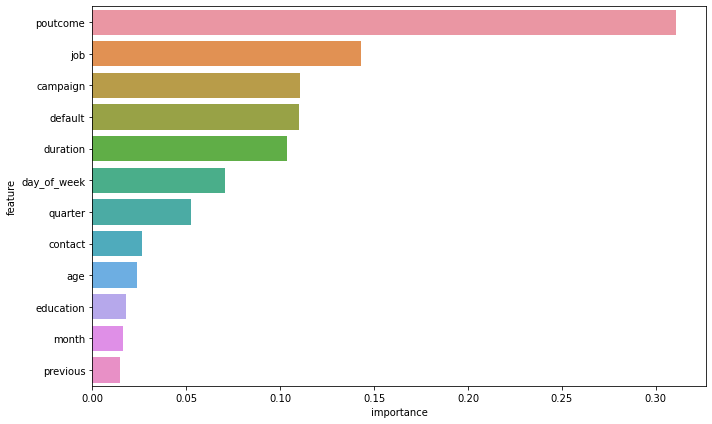

In [38]:
importance_df = pd.DataFrame({
    'feature' : X_train.columns,
    'importance' : xgb_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df)
plt.tight_layout()
plt.show()

## Shap Values

In [51]:
cat_transformer = Pipeline(steps=[('encoder', TargetEncoder(min_samples_leaf=100, smoothing=5))])
num_transformer = Pipeline(steps=[('identity', FunctionTransformer(func = None))])

preprocessor = ColumnTransformer(transformers=[
                                                ('num_trans', num_transformer, num_features),
                                                ('cat_trans', cat_transformer, cat_features)
                                            ],
                                remainder='drop')

X_train_shap = preprocessor.fit_transform(X_train, y_train)
X_train_shap = pd.DataFrame(X_train_shap, columns = X_train.columns)

In [45]:
shap_values = shap.TreeExplainer(xgb_model.named_steps['classifier']).shap_values(X_train_shap)

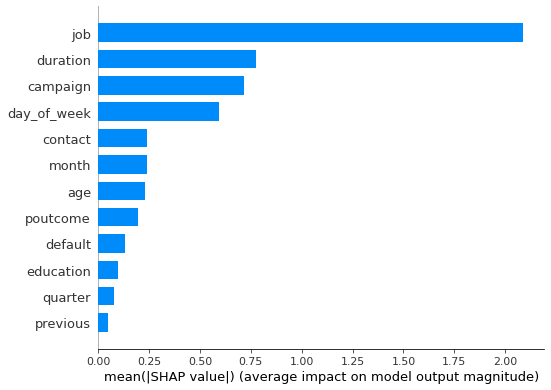

In [52]:
shap.summary_plot(shap_values, X_train_shap, plot_type="bar")

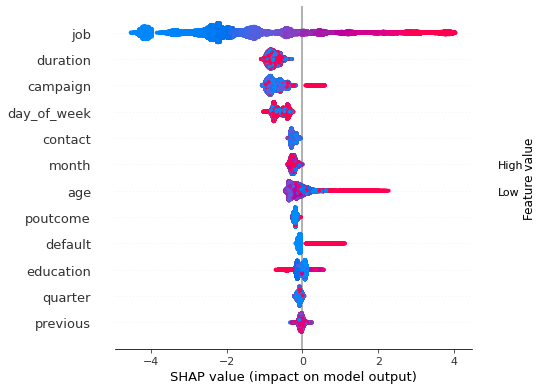

In [53]:
f = plt.figure()
shap.summary_plot(shap_values, X_train_shap)